In [1]:
import gym
from gym import envs
import time
from collections import namedtuple
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    from IPython.display import clear_output
    
plt.ion()

In [3]:
#REPLAY MEMORY

Transition = namedtuple('Transition', 
                        ('state', 'action', 'next_state', 'reward', 'goal'))

class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    
    def push(self, *args):
        '''Saves a transition.'''
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [4]:
class network(nn.Module):
    
    def __init__(self, input_dim, output_dim, units=100):
        super(network, self).__init__()
        self.layer1 = nn.Linear(input_dim, units)
        self.bn1 = nn.BatchNorm1d(units)
        self.layer2 = nn.Linear(units, units)
        self.bn2 = nn.BatchNorm1d(units)
        self.layer3 = nn.Linear(units, output_dim)   
        self.output_dim = output_dim
        
    def forward(self, x, debug=False):
        
        if debug:
            print(x.shape)
            x = F.relu(self.layer1(x))
            print(x.shape)
            x = F.relu(self.layer2(x))
            print(x.shape)        
            x = F.relu(self.layer3(x))
            print(x.shape)
        else:
            x = F.relu(self.bn1(self.layer1(x)))
            x = F.relu(self.bn2(self.layer2(x)))
            x = self.layer3(x)
        return x

In [5]:
class actor_network(nn.Module):
    
    def __init__(self, input_dim, output_dim, units=100):
        super(actor_network, self).__init__()
        self.layer1 = nn.Linear(input_dim, units)
        self.bn1 = nn.BatchNorm1d(units)
        self.layer2 = nn.Linear(units, units)
        self.bn2 = nn.BatchNorm1d(units)
        self.layer3 = nn.Linear(units, output_dim)
        
        self.tanh = nn.Tanh()
        
        self.output_dim = output_dim
        
    def forward(self, x, debug=False):
        
        if debug:
            print(x.shape)
            x = F.relu(self.layer1(x))
            print(x.shape)
            x = F.relu(self.layer2(x))
            print(x.shape)        
            x = F.relu(self.layer3(x))
            print(x.shape)
        else:
            x = F.relu(self.bn1(self.layer1(x)))
            x = F.relu(self.bn2(self.layer2(x)))  
            x = self.layer3(x)
        return self.tanh(x)

In [6]:
def weights_update(tau, target_network, network):
    for target_param, param in zip(target_network.parameters(), network.parameters()):
        target_param.data.copy_(tau*param.data + target_param.data*(1.0 - tau))

In [7]:
def plot_rewards(rewards):
    clear_output()
    plt.figure()
    rewards_tensor = torch.tensor(rewards, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(rewards_tensor.numpy())
    
    if len(rewards_tensor) >=100:
        means = rewards_tensor.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.ones(99)*-1, means))
        plt.plot(means.numpy())
        
    plt.show()

In [8]:
def optimize_model():
    if len(R) < BATCH_SIZE:
        return
   
    # sample a random minibatch of N transitions (si, ai, ri, si+1) from R

    transitions = R.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    # only include non-final states (final state is one after which the simulation ended)
    #non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    #non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    next_state_batch = torch.cat(batch.next_state)
    reward_batch = torch.cat(batch.reward)
    goal_batch = torch.cat(batch.goal)
    
    #next_state_values = torch.zeros(BATCH_SIZE, device=device)
    #next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    with torch.no_grad():
        # set yi = ri + gamma*Q'(si+1,mu'(si+1))
        target_actions = target_mu(torch.cat((next_state_batch, goal_batch),1))
        y = reward_batch.view(BATCH_SIZE,1) + GAMMA*target_Q(torch.cat((next_state_batch, target_actions, goal_batch),1))

    Q.train()
    # update critic by minimizing the MSE loss = 1/m sum (y - Q(si,ai))^2
    Q_optimizer.zero_grad()
    q = Q(torch.cat((state_batch, action_batch, goal_batch),1))
    #print(q)
    loss = ((y-q)**2).mean()   
    loss.backward()
    Q_optimizer.step()
    
    #for p in Q.parameters():
    #    p.requires_grad = False
        
    mu.train()
    mu_optimizer.zero_grad()
    # update the actor policy using the sampled policy gradient
    #gradient_mu = 1/N sum gradient(Q(si,mu(si)) wrt mu(si)) * gradient(mu(si), wrt mu.weights)
    actions = mu(torch.cat((state_batch, goal_batch), 1))
    values = Q(torch.cat((state_batch, actions, goal_batch),1))
    mean_target_values = -values.mean()
    mean_target_values.backward()
    mu_optimizer.step()
    
    #for p in Q.parameters():
    #    p.requries_grad = True
    
    # update target networks
    #target_Q.weights = tau*target_Q.weights + (1-tau)*Q.weights
    #target_mu.weights = tau*target_mu + (1-tau)*mu.weights
    weights_update(TAU, target_Q, Q)
    weights_update(TAU, target_mu, mu)
    #return mean_target_values

In [9]:
BATCH_SIZE = 256
GAMMA = 0.99
TAU = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [10]:
def compute_reward(state, goal):
    if state[0,0] >= goal and state[0,1] >=0:
        done = True
        reward = 100
    else:
        done = False
        reward = -1    
    return reward, done

In [14]:
def plot_mu(mu):
    plt.figure()
    mu.eval()
    results = np.zeros((5,10))
    for i, x in enumerate([-1.2, -1.0, -.8, -.6, -.4, -.2, 0, .2, .4, .6]):
        for j, v in enumerate([-0.07, -0.03, 0.0, 0.03, 0.07]):
            results[j,i] = mu.forward(torch.tensor([[x,v, 0.45]], dtype=torch.double))
    plt.imshow(results, cmap='bwr')
    plt.colorbar()
    plt.show()

In [15]:
def plot_Q(mu,action):
    plt.figure()
    mu.eval()
    results = np.zeros((5,10))
    for i, x in enumerate([-1.2, -1.0, -.8, -.6, -.4, -.2, 0, .2, .4, .6]):
        for j, v in enumerate([-0.07, -0.03, 0.0, 0.03, 0.07]):
            results[j,i] = mu.forward(torch.tensor([[x,v,action,0.45]], dtype=torch.double))
    plt.imshow(results, cmap='bwr')
    plt.colorbar()
    plt.show()

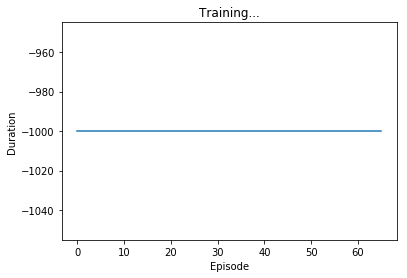

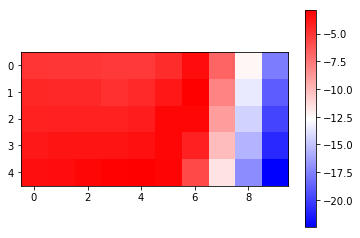

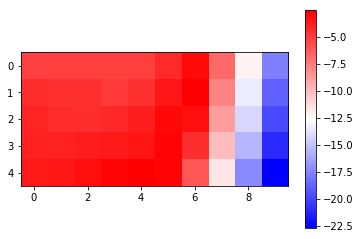

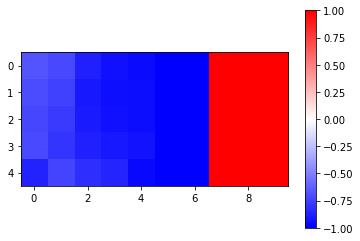

In [ ]:
#WITH HINDSIGHT EXPERIENCE REPLAY

# test with cart pole example to check that it works
np.random.seed(0)
torch.manual_seed(0)

rewards = []

# randomly initialize critic network Q and actor mu
Q = network(input_dim=4, output_dim=1).double().to(device)
mu = actor_network(input_dim=3, output_dim=1).double().to(device)

# create optimizers
Q_optimizer = optim.Adam(Q.parameters(), lr=0.001)
mu_optimizer = optim.Adam(mu.parameters(), lr=0.001)

# initialize target critic network Q' and target actor network mu' with same weights as Q and mu
target_Q = network(input_dim=4, output_dim=1).double().to(device)
weights_update(1, target_Q, Q)
for p in target_Q.parameters():
        p.requires_grad = False

target_mu = actor_network(input_dim=3, output_dim=1).double().to(device)
weights_update(1, target_mu, mu)
for p in target_mu.parameters():
        p.requires_grad = False
        
# initialize replay buffer R
R = ReplayMemory(1000000) # size of replay buffer is 10^6

env.close()
env = gym.make('MountainCarContinuous-v0') # set environment here
for i_episode in range(3000):
    episode_reward = 0
    
    # receive initial observation state s1
    state = env.reset()
    
    state = torch.tensor([state], dtype=torch.double, device=device)
    goal = torch.tensor([[0.45]], dtype=torch.double, device=device)
    
    initial_state = state
    
    done = False
    t = 0
    episode_R = ReplayMemory(50)
    max_episode_length = 1000       
    big_diff = 0
    new_goal = state[0,0]
    while t < max_episode_length and not done:
        t += 1
        env.render()
        
        # select action  
        #if i_episode % 10 != 0 or i_episode == 0:
        mu.eval()
        action = mu.forward(torch.cat((state,goal),1))[0]
            
        if i_episode < 10:
            action = torch.tensor(env.action_space.sample(), dtype=torch.double)
        else:
            if np.random.rand(1) < (1-t/max_episode_length):
                action = action + 1*torch.tensor(np.random.randn(1))
        action = torch.min(torch.max(action,torch.tensor(-1.0, dtype=torch.double)), torch.tensor(1.0, dtype=torch.double))
        
        # execute action at and observe reward rt and observe new state st+1

        next_state, reward, done, info = env.step(action.detach().numpy())
        next_state = torch.tensor([next_state], dtype=torch.double, device=device)
       
        reward, done = compute_reward(next_state, goal)
        reward = torch.tensor([reward], device=device)
         # store transition (st, at, st+1, rt) in R
        action = action.unsqueeze(0)
        R.push(state, action.detach(), next_state, reward, goal)
        episode_R.push(state, action.detach(), next_state, reward, goal)
        
        # move to the next state
        state = next_state
        
        if abs(initial_state[0,0] - state[0,0]) > big_diff:
            new_goal = state[0,0]
        
        if i_episode > 10:
            optimize_model()
        
        episode_reward = reward + episode_reward
        
        if done: 
            print(t)
            break

    
    # using final state
    '''for i in range(episode_R.position):
        state = episode_R.memory[i].state
        action = episode_R.memory[i].action
        new_reward = compute_reward(state, action, new_goal)
        next_state = episode_R.memory[i].next_state
        goal = new_goal.unsqueeze(0).unsqueeze(0)
        R.push(state, action, next_state, reward, goal)'''
       
    # plot rewards
    if i_episode % 1 == 0:
        
        rewards.append(episode_reward)
        plot_rewards(rewards)
        plot_Q(Q, 1)
        plot_Q(Q, -1)
        plot_mu(mu)
        